# pip installs

In [ ]:
!pip install datasets
!pip install wordcloud
!pip install gensim nltk scikit-learn tqdm
!pip install glove-python-binary
!pip install OpenAI
!pip install tiktoken
!pip install xgboost



ERROR: Could not find a version that satisfies the requirement glove-python-binary (from versions: none)
ERROR: No matching distribution found for glove-python-binary


# imports


In [1]:
#title
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
import re
import string
from matplotlib.patches import Patch
import nltk
from nltk import pos_tag, word_tokenize,pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from openai import OpenAI
import pandas as pd
import time
import os
import asyncio
import aiohttp
from openai import AsyncOpenAI
import nest_asyncio
import tiktoken
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from collections import Counter
from scipy.stats import entropy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import random


# downlodes

In [3]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# DATA creation

In [2]:
new_dataset = load_dataset("dmitva/human_ai_generated_text")
new_data = new_dataset["train"].to_pandas()
new_data.head()

,id,human_text,ai_text,instructions
0,cc902a20-27c4-4c18-8012-048a328206d1,Also they feel more comfortable at home. Some ...,"\n\nTherefore, when it comes to allowing stude...",Task: Write a persuasive essay on whether or n...
1,c4d2fbe3-e966-479d-89c4-62e1729b6255,"I can get another job to work on the weekends,...",It is important to weigh both the potential co...,Task: Research the advantages and disadvantage...
2,710f585e-5e98-42b8-81f6-265d7c934645,parents and school should agree on the desicio...,To ensure that parents are comfortable with th...,Task: \n\n1. Talk to your parents before takin...
3,e4db6c43-7b6b-4385-9b67-04652c71df0c,"Base in my experiences I'm growing, I try hard...","As Emerson said, by going confidently in the d...",Task: Write an essay discussing the benefits o...
4,7a48bcf1-cbb4-4f41-b99a-ea859c56afdf,Many people around the world have different ch...,"Parents, for example, can have a major influen...",Task: Research and discuss how character trait...


In [3]:
new_data= new_data[['human_text','instructions']]
new_data

,human_text,instructions
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...
2,parents and school should agree on the desicio...,Task: \n\n1. Talk to your parents before takin...
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...
4,Many people around the world have different ch...,Task: Research and discuss how character trait...
...,...,...
999995,You can meet up with your family at the park. ...,Task: Research reasons why people might find c...
999996,Even small chores prepare us for something big...,Task: \n\n1. Research the history of the US an...
999997,"Sometimes people say, ""technology is bad becau...",Task: Write an essay exploring how technology ...
999998,if we had enough time it would had really help...,Task: \n1. Research the effects of adding an a...


In [4]:
nest_asyncio.apply()


## OpenAI

In [ ]:


client = AsyncOpenAI(api_key="API_KEY")

# Load full dataset every time
df = new_data.copy()
df["ai_response"] = df.get("ai_response", None)

output_path = "ai_responses_progress.csv"
backup_path = "ai_responses_backup.csv"

# ----------------------------------------
# Restore progress WITHOUT replacing df
# ----------------------------------------
if os.path.exists(output_path):
    print("Merging saved progress...")
    saved = pd.read_csv(output_path)

    # Fill ai_response values for matching indices
    df.loc[saved.index, "ai_response"] = saved["ai_response"]


# ---------------------------
# ASYNC RESPONSE GENERATOR
# ---------------------------
async def generate_ai_response(instruction):
    while True:
        try:
            completion = await client.chat.completions.create(
                model="gpt-4.1-mini",
                messages=[
                    {"role": "system", "content": "Provide a full, coherent answer. Output ONLY the answer."},
                    {"role": "user", "content": str(instruction)}
                ],
                max_completion_tokens=400,
                temperature=0.7
            )
            return completion.choices[0].message.content.strip()

        except Exception as e:
            print("API error, retrying in 3 sec:", e)
            await asyncio.sleep(3)


# ---------------------------
# PROCESS CHUNK ASYNC
# ---------------------------
async def process_rows(start_row, stop_row, batch_size=20):

    tasks = []
    indices = []

    for idx in range(start_row, min(stop_row + 1, len(df))):

        response_val = str(df.loc[idx, "ai_response"]).strip().lower()

        # skip only if the row is truly finished
        if response_val not in ["", "nan"]:
            continue


        instruction = str(df.loc[idx, "instructions"])
        print(f"Queueing row {idx}: {instruction[:60]}...")

        task = asyncio.create_task(generate_ai_response(instruction))
        tasks.append(task)
        indices.append(idx)

        if len(tasks) >= batch_size:
            print(f"Running batch of {batch_size}...")
            results = await asyncio.gather(*tasks)

            for row_i, result in zip(indices, results):
                df.at[row_i, "ai_response"] = result

            df.to_csv(output_path, index=False)
            df.to_csv(backup_path, index=False)
            


            print("Saved batch!")
            tasks = []
            indices = []

    if tasks:
        print("Running final batch...")
        results = await asyncio.gather(*tasks)
        for row_i, result in zip(indices, results):
            df.at[row_i, "ai_response"] = result

        df.to_csv(output_path, index=False)
        df.to_csv(backup_path, index=False)
        print("Saved final batch!")


    print("\nALL DONE!")




Merging saved progress...


C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_6768\2314875714.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  saved = pd.read_csv(output_path)


In [ ]:
start_row = 0
stop_row = 9999

await process_rows(start_row, stop_row)


Queueing row 1590: Task: Task:

1. Research productive people, such as Steve Jo...
Queueing row 1591: Task: Task:

1. Research what Ralph Waldo Emerson's statemen...
Queueing row 1592: Task: Write an essay about the ways in which technology has ...
Queueing row 1593: Task: 

Write an essay discussing the pros and cons of allow...
Queueing row 1594: Task: Review current policy on cell phone use in the school ...
Queueing row 1595: Task: 

1. Identify examples of how people make first impres...
Queueing row 1596: Task: Write an essay explaining why extending the school day...
Queueing row 1597: Task: Write an essay discussing why it would be beneficial f...
Queueing row 1598: Task: Research the benefits of taking online classes, consid...
Queueing row 1599: Task: Analyze the benefits of asking for guidance from exper...
Queueing row 1600: Task: Research the advantages and disadvantages of having a ...
Queueing row 1601: Task: 

Write an essay comparing and contrasting the opinion...
Queu

## Local Models Ollama

### Bens Data creation

In [5]:
df = new_data.copy()


# Ensure columns exist
if "ai_response" not in df.columns:
    df["ai_response"] = None


if "ai_source" not in df.columns:
    df["ai_source"] = None


output_path = "ai_responses_progress.csv"


# ----------------------------------------



if os.path.exists(output_path):
    print("Restoring saved progress...")
    saved = pd.read_csv(output_path)


    df.loc[saved.index, "ai_response"] = saved["ai_response"]
    df.loc[saved.index, "ai_source"] = saved["ai_source"]


# ----------------------------------------




Restoring saved progress...


In [6]:


# Limit concurrency to 2 requests at a time
SEM = asyncio.Semaphore(2)


SYSTEM_PROMPT = ("Write like a real person, not an assistant. Vary sentence length and structure. Allow small imperfections and informal phrasing. Avoid structured or textbook-style writing. Do not explain your reasoning. Output only the response."
)


def clean_text(text: str) -> str:
    text = re.sub(r"^\s*#{1,6}\s*", "", text, flags=re.MULTILINE)
    return text.strip()


OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "phi3:mini"


async def generate_local_response(session, instruction):
    async with SEM:
        noise = random.choice([
            "You don’t need to be perfectly formal.",
            "Answer like you’re thinking out loud.",
            "It’s okay to be slightly unsure.",
            "Write the way someone would type, not publish."
        ])

        if random.random() < 0.25:
            noise += " Prefer verbs over abstract nouns when possible."

        STYLE_PROMPTS = [
            "Write casually, like a forum post.",
            "Write like a student answering quickly.",
            "Write like someone slightly tired.",
            "Write confidently but not formally.",
            "Write with mild uncertainty."
        ]

        style = random.choice(STYLE_PROMPTS)

        prompt = (
            f"{SYSTEM_PROMPT}\n"
            f"{noise}\n"
            f"Style: {style}\n\n"
            f"Task:\n{instruction}"
        )

        payload = {
            "model": MODEL_NAME,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.75,
                "top_p": 0.92,
                "top_k": 40,
                "num_predict": random.randint(320, 380)
            }
        }

        try:
            async with session.post(
                OLLAMA_URL,
                json=payload,
                timeout=aiohttp.ClientTimeout(total=180)
            ) as resp:
                data = await resp.json()
                text = data.get("response", "")
                return clean_text(text)

        except asyncio.TimeoutError:
            print("⏱️ Local model timed out, skipping")
            return ""

        except Exception as e:
            print("❌ Local model error:", e)
            return ""

COMMON_TYPO_MAP = {
    "because": "becuase",
    "definitely": "definately",
    "their": "thier",
    "really": "realy",
    "occurred": "occured",
    "separate": "seperate",
    "which": "wich",
    "doesn't": "doesnt",
    "don't": "dont",
    "became": "becmae",
    "people": "pepole",
    "different": "diffrent",
}


def maybe_punctuation_noise(text, prob=0.03):
    if random.random() > prob:
        return text

    # remove one comma or period
    return re.sub(r",", "", text, count=1)


def maybe_add_typo(text, prob=0.05):
    if len(text.split()) < 60:
        return text
     
    if random.random() > prob:
        return text
    

    words = text.split()
    candidates = [i for i, w in enumerate(words)
                  if w.lower().strip(".,!?") in COMMON_TYPO_MAP]

    if not candidates:
        return text

    idx = random.choice(candidates)
    clean = words[idx].lower().strip(".,!?")
    typo = COMMON_TYPO_MAP[clean]

    original = words[idx]
    words[idx] = re.sub(
        rf"\b{re.escape(clean)}\b",
        typo,
        original,
        flags=re.IGNORECASE
    )

    return " ".join(words)





async def process_rows_local(start_row, stop_row, max_new=7):
    generated = 0
    async with aiohttp.ClientSession() as session:
        for idx in range(start_row, min(stop_row + 1, len(df))):


            if generated >= max_new:
                print(f"Reached limit of {max_new} local responses.")
                break


            response_val = str(df.at[idx, "ai_response"]).strip().lower()
            if response_val not in ["", "nan", "none"]:
                continue


            instruction = str(df.at[idx, "instructions"])
            print(f"Local model processing row {idx}")


            # Generate text
            result = await generate_local_response(session, instruction)


            if result:
                result = maybe_add_typo(result)
                result = maybe_punctuation_noise(result)
                df.at[idx, "ai_response"] = result
                df.at[idx, "ai_source"] = "ollama_phi3_mini"
                generated += 1


                # Save after each success
                df.to_csv(output_path, index=False)


    print(f"\nLOCAL MODEL finished. Generated {generated} rows.")






In [9]:
# Run
asyncio.run(
    process_rows_local(
        start_row=12000,
        stop_row=12999,
        max_new=1000
    )
)


Local model processing row 12000
Local model processing row 12001
Local model processing row 12002
Local model processing row 12003
Local model processing row 12004
Local model processing row 12005
Local model processing row 12006
Local model processing row 12007
Local model processing row 12008
Local model processing row 12009
Local model processing row 12010
Local model processing row 12011
Local model processing row 12012
Local model processing row 12013
Local model processing row 12014
Local model processing row 12015
Local model processing row 12016
Local model processing row 12017
Local model processing row 12018
Local model processing row 12019
Local model processing row 12020
Local model processing row 12021
Local model processing row 12022
Local model processing row 12023
Local model processing row 12024
Local model processing row 12025
Local model processing row 12026
Local model processing row 12027
Local model processing row 12028
Local model processing row 12029
Local mode

In [10]:
df = df[df["ai_response"].notna()]
df

,human_text,instructions,ai_response,ai_source
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...,With the rapid advancement of technology and t...,openai_gpt4.1_mini
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...,The concept of a four-day school week has gain...,openai_gpt4.1_mini
2,parents and school should agree on the desicio...,Task: \n\n1. Talk to your parents before takin...,5. Make sure that activities you choose align ...,openai_gpt4.1_mini
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...,"Ralph Waldo Emerson once said, “Do not go wher...",openai_gpt4.1_mini
4,Many people around the world have different ch...,Task: Research and discuss how character trait...,Character traits in humans are formed through ...,openai_gpt4.1_mini
...,...,...,...,...
12995,"At this situation, we have seen many cases tha...",Task: Research the benefits of schools control...,Hey there! So I've been digging into this topi...,ollama_phi3_mini
12996,"They lost very badly, but that didn't stop the...",Task: Task:\n1. Research examples of people wh...,"Alright, listen up 'cause I got some real stor...",ollama_phi3_mini
12997,"For example, people will not have to take a bu...",Task: \n1. Research the current and projected ...,"Alright, I guess we're diving into this whole ...",ollama_phi3_mini
12998,They will take care of you not only that you a...,Task: Write an essay explaining the pros and c...,"When I first started pondering this topic, it ...",ollama_phi3_mini


In [11]:
output_path = "ai_responses_progress.csv"
df.to_csv(output_path, index=False)

### Dolevs Data Creation

In [27]:
# ==========================
# important - Enter number of rows to process
# ==========================

start_row = 11000
stop_row = 11003

In [ ]:
df = new_data.copy()


# Ensure columns exist
if "ai_response" not in df.columns:
    df["ai_response"] = None


if "ai_source" not in df.columns:
    df["ai_source"] = None


output_path = "ai_responses_progress.csv"


# ----------------------------------------



if os.path.exists(output_path):
    print("Restoring saved progress...")
    saved = pd.read_csv(output_path)


    df.loc[saved.index, "ai_response"] = saved["ai_response"]
    df.loc[saved.index, "ai_source"] = saved["ai_source"]


# ----------------------------------------
output_path = "ai_responses_progress_sub_Dolev.csv"


Restoring saved progress...


In [ ]:


# Limit concurrency to 2 requests at a time
SEM = asyncio.Semaphore(2)


SYSTEM_PROMPT = ("Write like a real person, not an assistant. Vary sentence length and structure. Allow small imperfections and informal phrasing. Avoid structured or textbook-style writing. Do not explain your reasoning. Output only the response."
)


def clean_text(text: str) -> str:
    text = re.sub(r"^\s*#{1,6}\s*", "", text, flags=re.MULTILINE)
    return text.strip()


OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "phi3:mini"


async def generate_local_response(session, instruction):
    async with SEM:
        noise = random.choice([
            "You don’t need to be perfectly formal.",
            "Answer like you’re thinking out loud.",
            "It’s okay to be slightly unsure.",
            "Write the way someone would type, not publish."
        ])

        if random.random() < 0.25:
            noise += " Prefer verbs over abstract nouns when possible."

        STYLE_PROMPTS = [
            "Write casually, like a forum post.",
            "Write like a student answering quickly.",
            "Write like someone slightly tired.",
            "Write confidently but not formally.",
            "Write with mild uncertainty."
        ]

        style = random.choice(STYLE_PROMPTS)

        prompt = (
            f"{SYSTEM_PROMPT}\n"
            f"{noise}\n"
            f"Style: {style}\n\n"
            f"Task:\n{instruction}"
        )

        payload = {
            "model": MODEL_NAME,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.75,
                "top_p": 0.92,
                "top_k": 40,
                "num_predict": random.randint(320, 380)
            }
        }

        try:
            async with session.post(
                OLLAMA_URL,
                json=payload,
                timeout=aiohttp.ClientTimeout(total=180)
            ) as resp:
                data = await resp.json()
                text = data.get("response", "")
                return clean_text(text)

        except asyncio.TimeoutError:
            print("⏱️ Local model timed out, skipping")
            return ""

        except Exception as e:
            print("❌ Local model error:", e)
            return ""

COMMON_TYPO_MAP = {
    "because": "becuase",
    "definitely": "definately",
    "their": "thier",
    "really": "realy",
    "occurred": "occured",
    "separate": "seperate",
    "which": "wich",
    "doesn't": "doesnt",
    "don't": "dont",
    "became": "becmae",
    "people": "pepole",
    "different": "diffrent",
}


def maybe_punctuation_noise(text, prob=0.03):
    if random.random() > prob:
        return text

    # remove one comma or period
    return re.sub(r",", "", text, count=1)


def maybe_add_typo(text, prob=0.05):
    if len(text.split()) < 60:
        return text
     
    if random.random() > prob:
        return text
    

    words = text.split()
    candidates = [i for i, w in enumerate(words)
                  if w.lower().strip(".,!?") in COMMON_TYPO_MAP]

    if not candidates:
        return text

    idx = random.choice(candidates)
    clean = words[idx].lower().strip(".,!?")
    typo = COMMON_TYPO_MAP[clean]

    original = words[idx]
    words[idx] = re.sub(
        rf"\b{re.escape(clean)}\b",
        typo,
        original,
        flags=re.IGNORECASE
    )

    return " ".join(words)





async def process_rows_local(start_row, stop_row, max_new=7):
    generated = 0
    async with aiohttp.ClientSession() as session:
        for idx in range(start_row, min(stop_row + 1, len(df))):


            if generated >= max_new:
                print(f"Reached limit of {max_new} local responses.")
                break


            response_val = str(df.at[idx, "ai_response"]).strip().lower()
            if response_val not in ["", "nan", "none"]:
                continue


            instruction = str(df.at[idx, "instructions"])
            print(f"Local model processing row {idx}")


            # Generate text
            result = await generate_local_response(session, instruction)


            if result:
                result = maybe_add_typo(result)
                result = maybe_punctuation_noise(result)
                df.at[idx, "ai_response"] = result
                df.at[idx, "ai_source"] = "ollama_phi3_mini"
                generated += 1


                # Save after each success
                df.to_csv(output_path, index=False)


    print(f"\nLOCAL MODEL finished. Generated {generated} rows.")






In [ ]:
# Run
asyncio.run(
    process_rows_local(
        start_row=start_row,
        stop_row=stop_row,
        max_new=1000
    )
)


Local model processing row 11000
Local model processing row 11001
Local model processing row 11002
Local model processing row 11003

LOCAL MODEL finished. Generated 4 rows.


In [ ]:
df = df[start_row:stop_row+1]
df.to_csv(output_path, index=False)
df

,human_text,instructions,ai_response,ai_source
11000,They are also getting to know each other.\n\nS...,Task: Compare and contrast the advantages of w...,Working in a group has its own set of benefits...,ollama_phi3_mini
11001,An employer with a open mind may see an employ...,Task: Research how open-minded people and seco...,Open-mindedness is essential when it comes to ...,ollama_phi3_mini
11002,How I hope I showed you what is good for askin...,Task: Task:\nIdentify the benefits of asking p...,Asking people for advice can be incredibly ben...,ollama_phi3_mini
11003,The program also help a lot to the students. T...,Task: Write an essay about the effects of a pr...,"In recent years, educational institutions have...",ollama_phi3_mini


### Alons Data Creation

In [ ]:
# ==========================
# important - Enter number of rows to process
# ==========================

start_row = 12000
stop_row = 13000

In [ ]:
df = new_data.copy()


# Ensure columns exist
if "ai_response" not in df.columns:
    df["ai_response"] = None


if "ai_source" not in df.columns:
    df["ai_source"] = None


output_path = "ai_responses_progress.csv"


# ----------------------------------------



if os.path.exists(output_path):
    print("Restoring saved progress...")
    saved = pd.read_csv(output_path)


    df.loc[saved.index, "ai_response"] = saved["ai_response"]
    df.loc[saved.index, "ai_source"] = saved["ai_source"]


# ----------------------------------------
output_path = "ai_responses_progress_sub_Alon.csv"


In [ ]:


# Limit concurrency to 2 requests at a time
SEM = asyncio.Semaphore(2)


SYSTEM_PROMPT = ("Write like a real person, not an assistant. Vary sentence length and structure. Allow small imperfections and informal phrasing. Avoid structured or textbook-style writing. Do not explain your reasoning. Output only the response."
)


def clean_text(text: str) -> str:
    text = re.sub(r"^\s*#{1,6}\s*", "", text, flags=re.MULTILINE)
    return text.strip()


OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "phi3:mini"


async def generate_local_response(session, instruction):
    async with SEM:
        noise = random.choice([
            "You don’t need to be perfectly formal.",
            "Answer like you’re thinking out loud.",
            "It’s okay to be slightly unsure.",
            "Write the way someone would type, not publish."
        ])

        if random.random() < 0.25:
            noise += " Prefer verbs over abstract nouns when possible."

        STYLE_PROMPTS = [
            "Write casually, like a forum post.",
            "Write like a student answering quickly.",
            "Write like someone slightly tired.",
            "Write confidently but not formally.",
            "Write with mild uncertainty."
        ]

        style = random.choice(STYLE_PROMPTS)

        prompt = (
            f"{SYSTEM_PROMPT}\n"
            f"{noise}\n"
            f"Style: {style}\n\n"
            f"Task:\n{instruction}"
        )

        payload = {
            "model": MODEL_NAME,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.75,
                "top_p": 0.92,
                "top_k": 40,
                "num_predict": random.randint(320, 380)
            }
        }

        try:
            async with session.post(
                OLLAMA_URL,
                json=payload,
                timeout=aiohttp.ClientTimeout(total=180)
            ) as resp:
                data = await resp.json()
                text = data.get("response", "")
                return clean_text(text)

        except asyncio.TimeoutError:
            print("⏱️ Local model timed out, skipping")
            return ""

        except Exception as e:
            print("❌ Local model error:", e)
            return ""

COMMON_TYPO_MAP = {
    "because": "becuase",
    "definitely": "definately",
    "their": "thier",
    "really": "realy",
    "occurred": "occured",
    "separate": "seperate",
    "which": "wich",
    "doesn't": "doesnt",
    "don't": "dont",
    "became": "becmae",
    "people": "pepole",
    "different": "diffrent",
}


def maybe_punctuation_noise(text, prob=0.03):
    if random.random() > prob:
        return text

    # remove one comma or period
    return re.sub(r",", "", text, count=1)


def maybe_add_typo(text, prob=0.05):
    if len(text.split()) < 60:
        return text
     
    if random.random() > prob:
        return text
    

    words = text.split()
    candidates = [i for i, w in enumerate(words)
                  if w.lower().strip(".,!?") in COMMON_TYPO_MAP]

    if not candidates:
        return text

    idx = random.choice(candidates)
    clean = words[idx].lower().strip(".,!?")
    typo = COMMON_TYPO_MAP[clean]

    original = words[idx]
    words[idx] = re.sub(
        rf"\b{re.escape(clean)}\b",
        typo,
        original,
        flags=re.IGNORECASE
    )

    return " ".join(words)





async def process_rows_local(start_row, stop_row, max_new=7):
    generated = 0
    async with aiohttp.ClientSession() as session:
        for idx in range(start_row, min(stop_row + 1, len(df))):


            if generated >= max_new:
                print(f"Reached limit of {max_new} local responses.")
                break


            response_val = str(df.at[idx, "ai_response"]).strip().lower()
            if response_val not in ["", "nan", "none"]:
                continue


            instruction = str(df.at[idx, "instructions"])
            print(f"Local model processing row {idx}")


            # Generate text
            result = await generate_local_response(session, instruction)


            if result:
                result = maybe_add_typo(result)
                result = maybe_punctuation_noise(result)
                df.at[idx, "ai_response"] = result
                df.at[idx, "ai_source"] = "ollama_phi3_mini"
                generated += 1


                # Save after each success
                df.to_csv(output_path, index=False)


    print(f"\nLOCAL MODEL finished. Generated {generated} rows.")






In [ ]:
# Run
asyncio.run(
    process_rows_local(
        start_row=start_row,
        stop_row=stop_row,
        max_new=1000
    )
)


In [ ]:
df = df[start_row:stop_row+1]
df.to_csv(output_path, index=False)
df

# Creating DF

In [13]:
df = pd.read_csv("ai_responses_progress.csv")
df

,human_text,instructions,ai_response,ai_source
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...,With the rapid advancement of technology and t...,openai_gpt4.1_mini
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...,The concept of a four-day school week has gain...,openai_gpt4.1_mini
2,parents and school should agree on the desicio...,Task: \r\n\r\n1. Talk to your parents before t...,5. Make sure that activities you choose align ...,openai_gpt4.1_mini
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...,"Ralph Waldo Emerson once said, “Do not go wher...",openai_gpt4.1_mini
4,Many people around the world have different ch...,Task: Research and discuss how character trait...,Character traits in humans are formed through ...,openai_gpt4.1_mini
...,...,...,...,...
10631,I think that thats why they should have many m...,Task: Research the various job opportunities a...,Hey there! I've been thinking about what job o...,ollama_phi3_mini
10632,One example of that is when i was little i alw...,Task: Task:\r\n\r\nWrite an essay discussing h...,I remember growing up with an immense sense of...,ollama_phi3_mini
10633,Teachers and parents may even realize that it ...,Task: Research the pros and cons of having stu...,"Hey, I was doing some thinking about this whol...",ollama_phi3_mini
10634,"However , if you don't do nothing beyond what ...",Task: \r\nWrite an essay that agrees or disagr...,"I wholeheartedly agree with the statement ""If ...",ollama_phi3_mini


In [14]:

enc = tiktoken.get_encoding("cl100k_base")

def truncate_to_n_tokens(text, n=350):
    if not isinstance(text, str):
        return text
    tokens = enc.encode(text)
    tokens = tokens[:n]
    return enc.decode(tokens)

df["human_text_350"] = df["human_text"].apply(lambda x: truncate_to_n_tokens(x,350))
df["ai_text_350"] = df["ai_response"].apply(lambda x: truncate_to_n_tokens(x, 350))



In [15]:
df = df[['instructions','human_text','ai_response','human_text_350','ai_text_350']]
df.head()

,instructions,human_text,ai_response,human_text_350,ai_text_350
0,Task: Write a persuasive essay on whether or n...,Also they feel more comfortable at home. Some ...,With the rapid advancement of technology and t...,Also they feel more comfortable at home. Some ...,With the rapid advancement of technology and t...
1,Task: Research the advantages and disadvantage...,"I can get another job to work on the weekends,...",The concept of a four-day school week has gain...,"I can get another job to work on the weekends,...",The concept of a four-day school week has gain...
2,Task: \r\n\r\n1. Talk to your parents before t...,parents and school should agree on the desicio...,5. Make sure that activities you choose align ...,parents and school should agree on the desicio...,5. Make sure that activities you choose align ...
3,Task: Write an essay discussing the benefits o...,"Base in my experiences I'm growing, I try hard...","Ralph Waldo Emerson once said, “Do not go wher...","Base in my experiences I'm growing, I try hard...","Ralph Waldo Emerson once said, “Do not go wher..."
4,Task: Research and discuss how character trait...,Many people around the world have different ch...,Character traits in humans are formed through ...,Many people around the world have different ch...,Character traits in humans are formed through ...


# EDA

In [16]:
df.shape

(10636, 5)

In [17]:
df.isnull().sum()

instructions      0
human_text        0
ai_response       0
human_text_350    0
ai_text_350       0
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10636 entries, 0 to 10635
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   instructions    10636 non-null  object
 1   human_text      10636 non-null  object
 2   ai_response     10636 non-null  object
 3   human_text_350  10636 non-null  object
 4   ai_text_350     10636 non-null  object
dtypes: object(5)
memory usage: 415.6+ KB


In [19]:
df.describe()

,instructions,human_text,ai_response,human_text_350,ai_text_350
count,10636,10636,10636,10636,10636
unique,2420,9966,10625,9952,10625
top,Task: Write an essay discussing the pros and c...,"Why should someone, tell people what matters i...",audiences by rehearsing regularly and building...,i like to work with a group a cash if you work...,audiences by rehearsing regularly and building...
freq,9,5,4,5,4


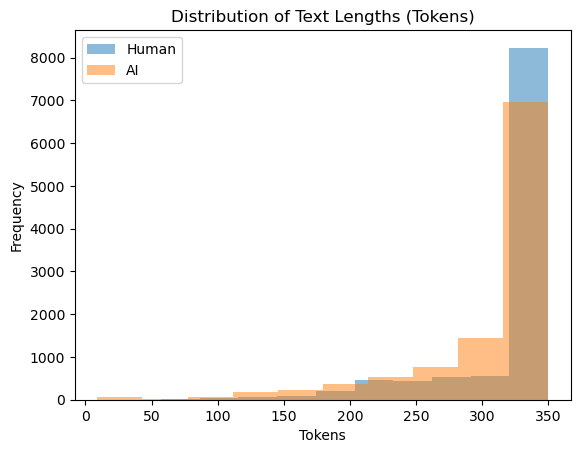

In [20]:

enc = tiktoken.get_encoding("cl100k_base")

# Count tokens instead of words
df['human_token_len'] = df['human_text_350'].apply(
    lambda x: len(enc.encode(x)) if isinstance(x, str) else None
)

df['ai_token_len'] = df['ai_text_350'].apply(
    lambda x: len(enc.encode(x)) if isinstance(x, str) else None
)

# Plot token distributions
plt.hist(df['human_token_len'].dropna(), alpha=0.5, label='Human')
plt.hist(df['ai_token_len'].dropna(), alpha=0.5, label='AI')
plt.legend()
plt.title("Distribution of Text Lengths (Tokens)")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()


In [21]:
avg_lengths = {
    'Human': df['human_len'].mean(),
    'AI': df['ai_len'].mean()
}

plt.bar(avg_lengths.keys(), avg_lengths.values())
plt.title("Average Text Length by Column")
plt.ylabel("Avg Words")
plt.show()

KeyError: 'human_len'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


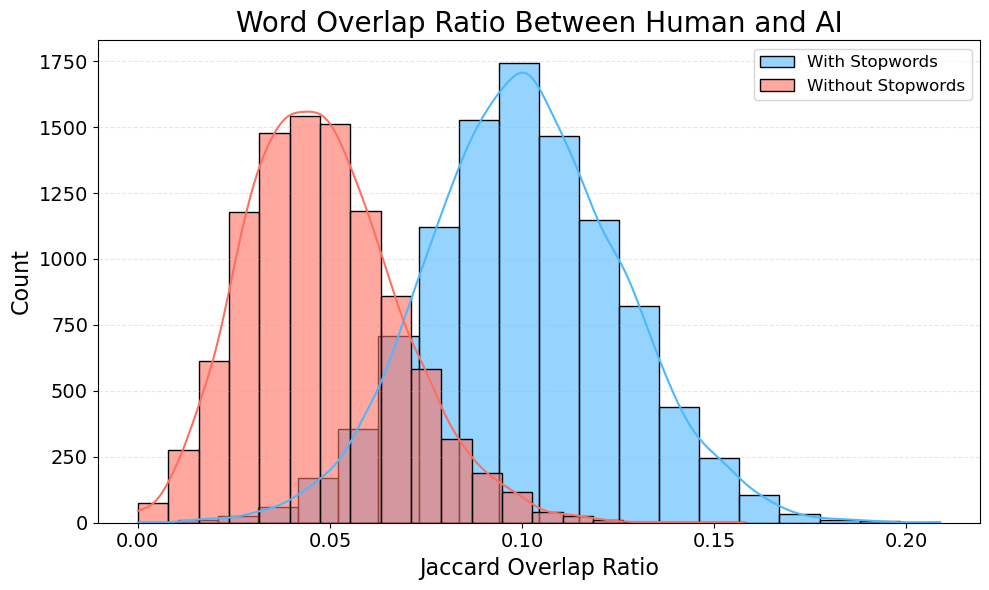

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

# פונקציה: overlap בלי stopwords
def word_overlap_no_stopwords(h, a):
    h_words = set(w for w in str(h).split() if w.lower() not in stop_words)
    a_words = set(w for w in str(a).split() if w.lower() not in stop_words)
    if not h_words or not a_words:
        return 0
    return len(h_words & a_words) / len(h_words | a_words)

# פונקציה: overlap כולל stopwords
def word_overlap(h, a):
    h_set = set(str(h).split())
    a_set = set(str(a).split())
    if not h_set or not a_set:
        return 0
    return len(h_set & a_set) / len(h_set | a_set)

# חישוב
overlap_with = df.apply(lambda row: word_overlap(row["human_text_350"], row["ai_text_350"]), axis=1)
overlap_no_stop = df.apply(lambda row: word_overlap_no_stopwords(row["human_text_350"], row["ai_text_350"]), axis=1)

# --- Plot ---
plt.figure(figsize=(10,6))
sns.histplot(overlap_with, bins=20, kde=True, color="#4DB8FF", label="With Stopwords", alpha=0.6)
sns.histplot(overlap_no_stop, bins=20, kde=True, color="#FF6F61", label="Without Stopwords", alpha=0.6)

plt.title("Word Overlap Ratio Between Human and AI", fontsize=20)
plt.xlabel("Jaccard Overlap Ratio", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

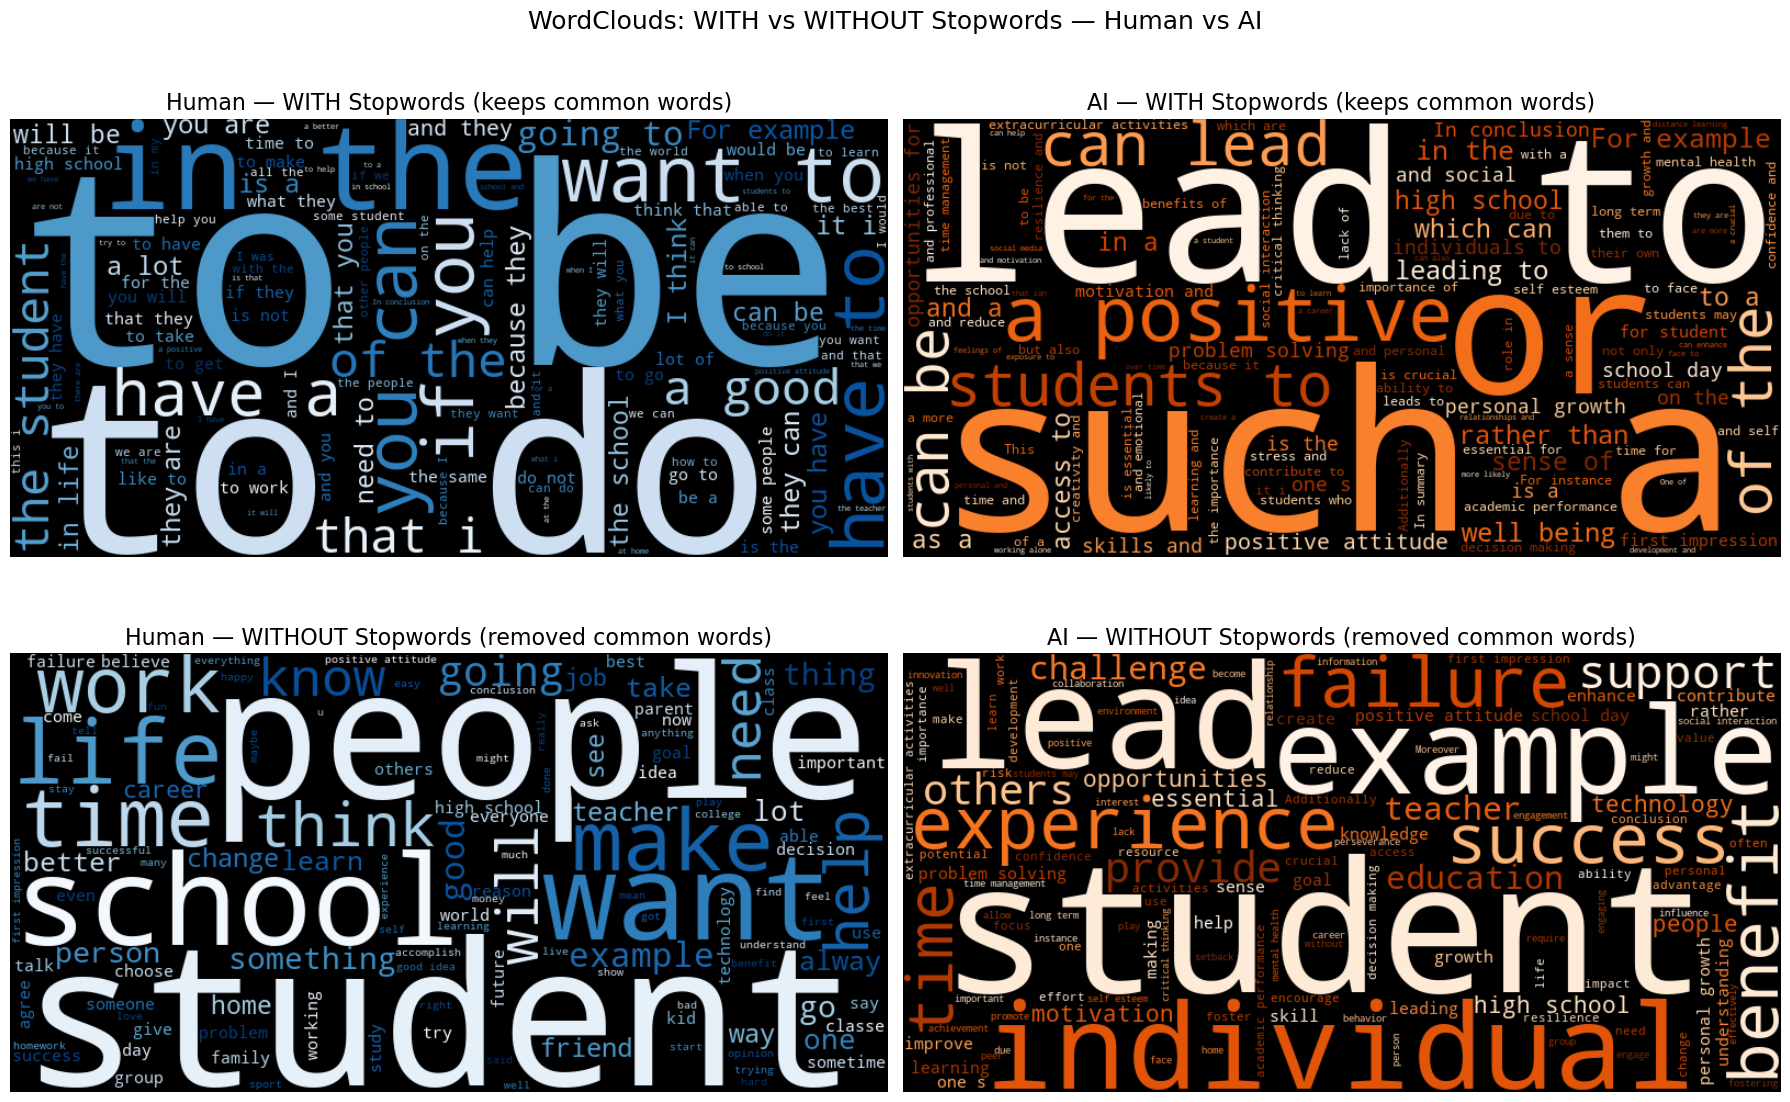

In [ ]:

# --- Parameters you can change ---
# אם הטקסטים שלך בעברית, תחליף english_stopwords ברשימת stopwords בעברית
english_stopwords = set(STOPWORDS)   # standard english stopwords
use_collocations = True             # True = include bigrams; False = single-word only
random_state = 42
wc_width, wc_height = 800, 400
max_words = 120

# --- Prepare texts ---
human_text = " ".join(df['human_text_350'].dropna().astype(str))
ai_text    = " ".join(df['ai_text_350'].dropna().astype(str))

# --- Shared WordCloud params ---
base_params = dict(
    width=wc_width,
    height=wc_height,
    background_color="black",
    collocations=use_collocations,
    random_state=random_state,
    max_words=max_words
)

# --- Create 4 word clouds
# Note the naming: WITHOUT stopwords => we REMOVE stopwords => pass stopwords=english_stopwords
#           WITH stopwords    => we KEEP stopwords      => pass stopwords=set()
wc_human_withSW    = WordCloud(**base_params, colormap="Blues",   stopwords=set()).generate(human_text or " ")
wc_human_withoutSW = WordCloud(**base_params, colormap="Blues",   stopwords=english_stopwords).generate(human_text or " ")

wc_ai_withSW       = WordCloud(**base_params, colormap="Oranges", stopwords=set()).generate(ai_text or " ")
wc_ai_withoutSW    = WordCloud(**base_params, colormap="Oranges", stopwords=english_stopwords).generate(ai_text or " ")

# --- Plot 2x2 (top-left = WITH stopwords, bottom-left = WITHOUT stopwords) ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

axes[0,0].imshow(wc_human_withSW, interpolation="bilinear")
axes[0,0].set_title("Human — WITH Stopwords (keeps common words)", fontsize=16)
axes[0,0].axis("off")

axes[1,0].imshow(wc_human_withoutSW, interpolation="bilinear")
axes[1,0].set_title("Human — WITHOUT Stopwords (removed common words)", fontsize=16)
axes[1,0].axis("off")

axes[0,1].imshow(wc_ai_withSW, interpolation="bilinear")
axes[0,1].set_title("AI — WITH Stopwords (keeps common words)", fontsize=16)
axes[0,1].axis("off")

axes[1,1].imshow(wc_ai_withoutSW, interpolation="bilinear")
axes[1,1].set_title("AI — WITHOUT Stopwords (removed common words)", fontsize=16)
axes[1,1].axis("off")

plt.suptitle("WordClouds: WITH vs WITHOUT Stopwords — Human vs AI", fontsize=18)
plt.tight_layout()
plt.show()

C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_1332\3668757483.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


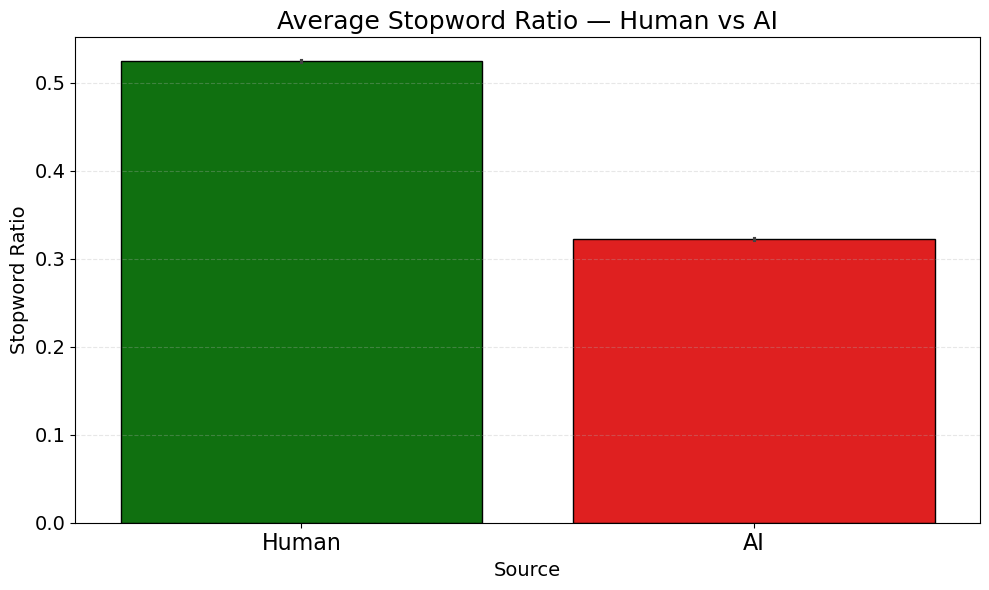

In [ ]:
stop_words = set(stopwords.words("english"))

def stopword_ratio(text):
    words = text.split()
    if len(words)==0: return 0
    return sum(1 for w in words if w.lower() in stop_words)/len(words)

df_stop = pd.DataFrame({
    "Human": df["human_text_350"].fillna("").astype(str).map(stopword_ratio),
    "AI": df["ai_text_350"].fillna("").astype(str).map(stopword_ratio),
})

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_stop.melt(var_name="source", value_name="stopword_ratio"), 
    x="source", 
    y="stopword_ratio", 
    palette=["green","red"],  # ירוק ל-Human, אדום ל-AI
    edgecolor="black"
)
plt.title("Average Stopword Ratio — Human vs AI", fontsize=18)
plt.ylabel("Stopword Ratio", fontsize=14)
plt.xlabel("Source", fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1800x800 with 0 Axes>

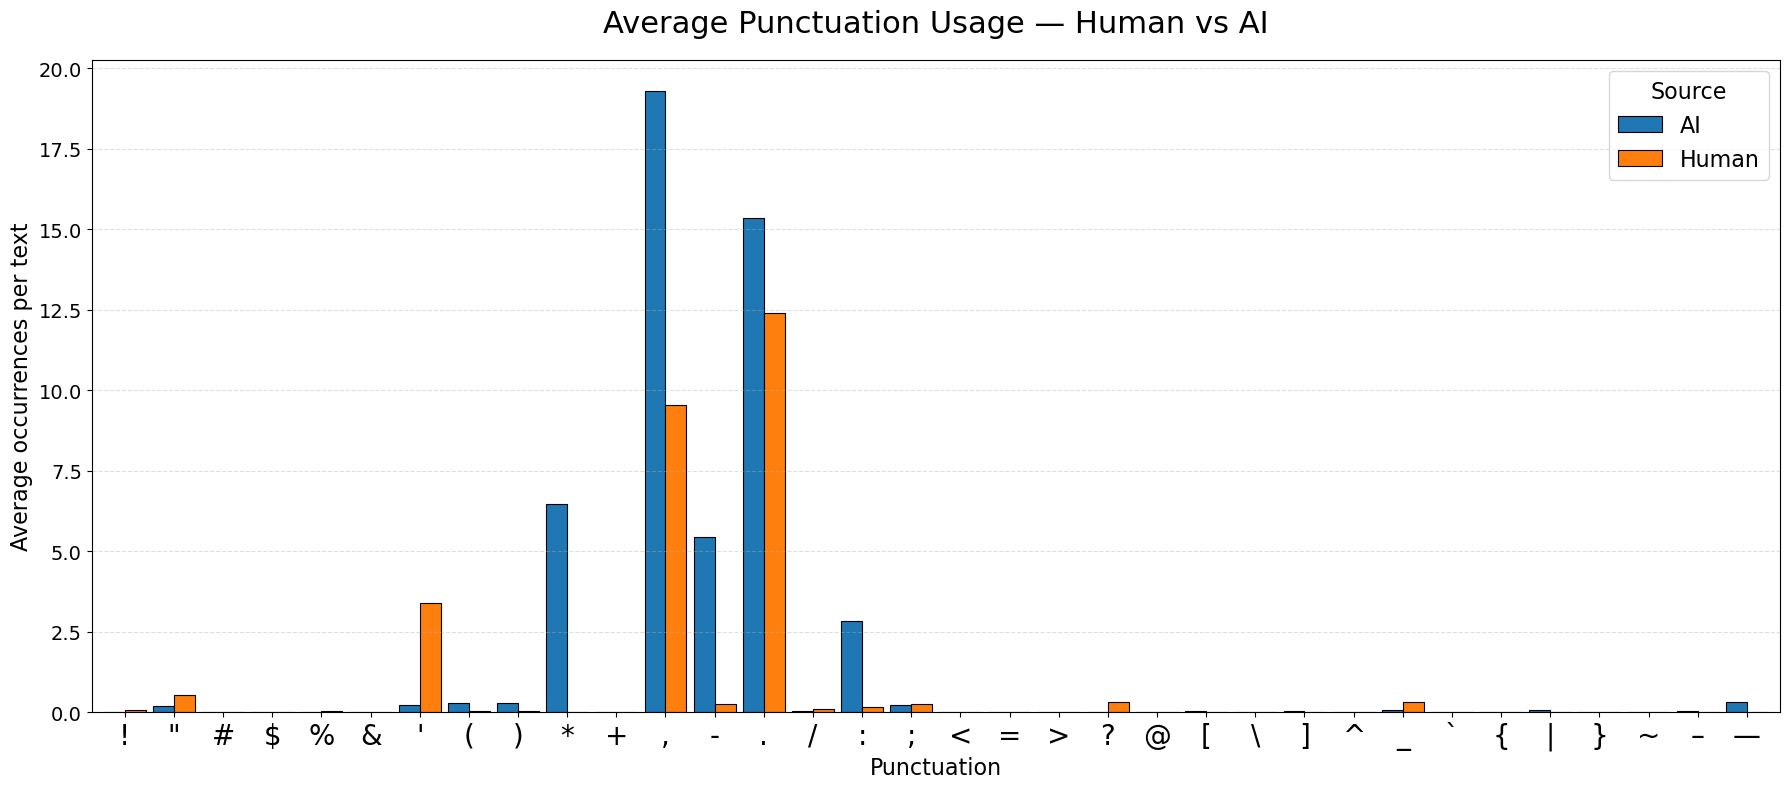

In [ ]:

# -------------------------
# Normalize DF into "source" + "text" structure (Human & AI)
# -------------------------
df_punct = pd.DataFrame({
    "source": ["Human"] * len(df) + ["AI"] * len(df),
    "text":   df["human_text_350"].fillna("").astype(str).tolist()
            + df["ai_text_350"].fillna("").astype(str).tolist()
})

# -------------------------
# Define punctuation char list (includes en dash & em dash)
# -------------------------
punctuations = string.punctuation + "–—"

# For plotting purposes, we capture readable names:
def safe_name(p):
    if p == "–": return "endash"
    if p == "—": return "emdash"
    return p

# -------------------------
# Count punctuation occurrences per text
# -------------------------
for p in punctuations:
    df_punct[f"count_{safe_name(p)}"] = df_punct["text"].str.count(re.escape(p))

# -------------------------
# Compute mean usage per punctuation per source
# -------------------------
punct_avg = (
    df_punct.groupby("source")[
        [col for col in df_punct.columns if col.startswith("count_")]
    ]
    .mean()
    .T
)

# Replace safe names back to real characters
punct_avg.index = (
    punct_avg.index.str.replace("count_", "", regex=False)
                   .str.replace("endash", "–", regex=False)
                   .str.replace("emdash", "—", regex=False)
)

# -------------------------
# Final high-quality plot
# -------------------------
plt.figure(figsize=(18, 8))
punct_avg.plot(
    kind="bar",
    figsize=(18, 8),
    width=0.85,
    edgecolor="black",
    linewidth=0.8
)

plt.title("Average Punctuation Usage — Human vs AI", fontsize=22, pad=20)
plt.ylabel("Average occurrences per text", fontsize=16)
plt.xlabel("Punctuation", fontsize=16)

plt.xticks(fontsize=20, rotation=0, ha="center")
plt.yticks(fontsize=14)
plt.legend(fontsize=16, title="Source", title_fontsize=16)

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:

# נניח שיש לך df עם העמודות human_text ו-ai_response
# נמזג אותם ל-DF אחיד עם 'source' ו-'text'
df_ratio = pd.DataFrame({
    "source": ["Human"]*len(df) + ["AI"]*len(df),
    "text":   df["human_text_350"].fillna("").astype(str).tolist()
             + df["ai_text_350"].fillna("").astype(str).tolist()
})

# פונקציה שמחשבת unique word ratio
def unique_ratio(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

df_ratio["unique_ratio"] = df_ratio["text"].apply(unique_ratio)

# ממוצע לכל source
avg_unique_ratio = df_ratio.groupby("source")["unique_ratio"].mean().reset_index()
avg_unique_ratio.columns = ["source", "avg_unique_ratio"]

print(avg_unique_ratio)

  source  avg_unique_ratio
0     AI          0.699022
1  Human          0.476141


C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_1332\3754287975.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


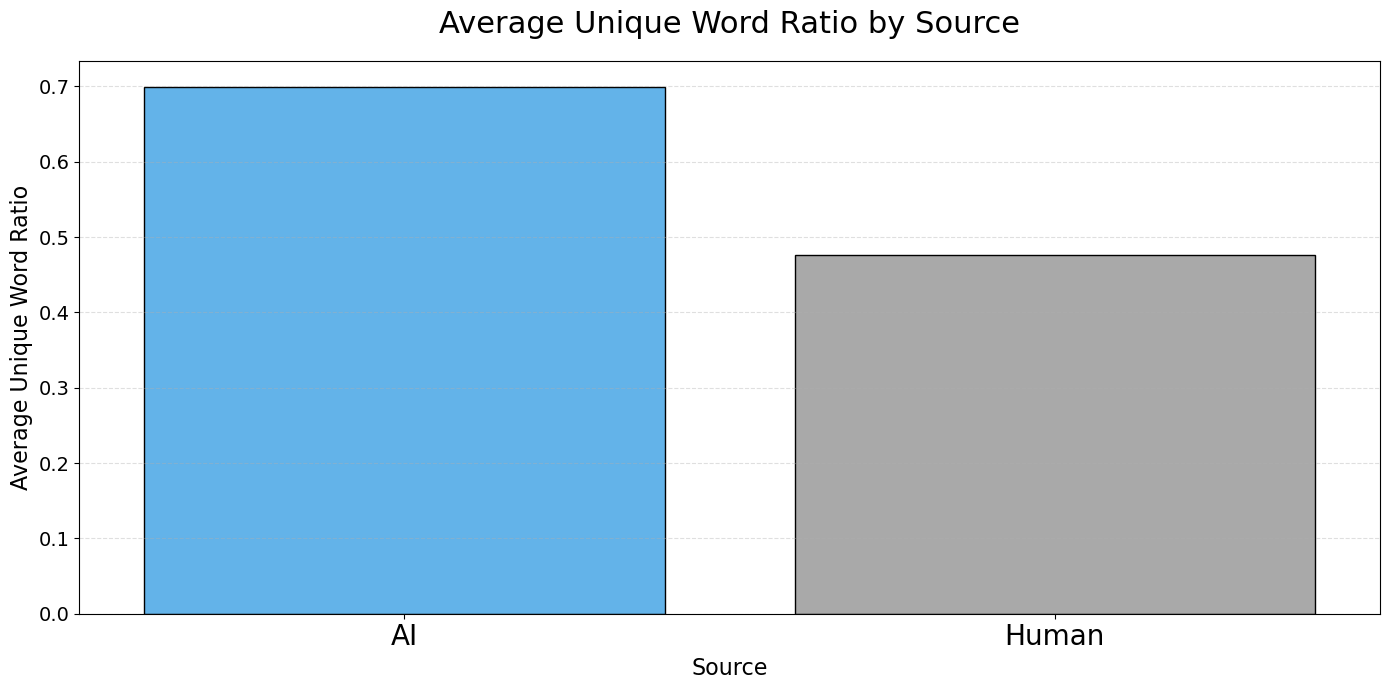

In [ ]:
plt.figure(figsize=(14,7))
sns.barplot(
    data=avg_unique_ratio,
    x="source",
    y="avg_unique_ratio",
    palette=["#4DB8FF", "#A9A9A9"],  # תכלת ל-Human, אפור ל-AI
    edgecolor="black"
)

plt.title("Average Unique Word Ratio by Source", fontsize=22, pad=20)
plt.xlabel("Source", fontsize=16)
plt.ylabel("Average Unique Word Ratio", fontsize=16)
plt.xticks(fontsize=20, rotation=0, ha="center")
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



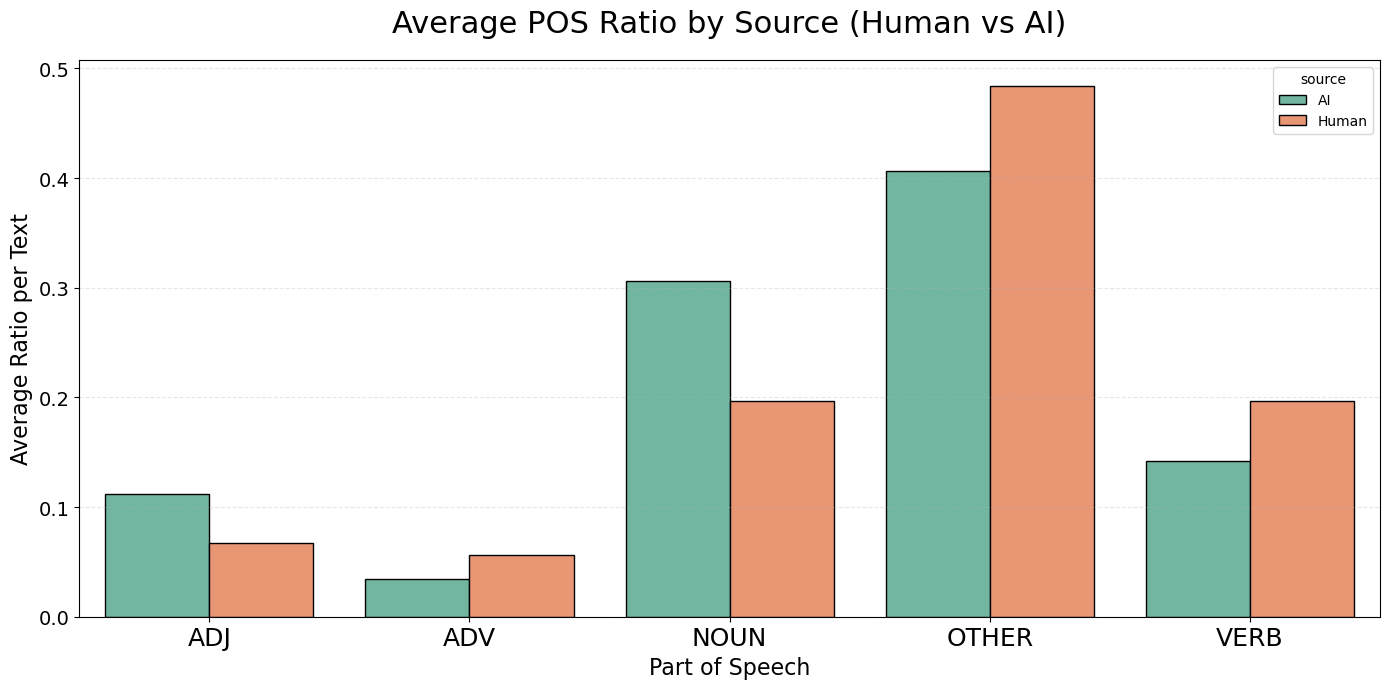

In [ ]:

# --- POS Tagging Function ---
def get_pos_groups(text):
    """Return POS counts for a single text as a dict"""
    counts = {"NOUN":0, "VERB":0, "ADJ":0, "ADV":0, "OTHER":0}
    if not isinstance(text, str):
        return counts
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    for _, pos in tags:
        if pos.startswith("N"):
            counts["NOUN"] += 1
        elif pos.startswith("V"):
            counts["VERB"] += 1
        elif pos.startswith("J"):
            counts["ADJ"] += 1
        elif pos.startswith("R"):
            counts["ADV"] += 1
        else:
            counts["OTHER"] += 1
    return counts

# --- Prepare POS counts for Human and AI ---
records = []

for source_name, col in [("Human","human_text_350"), ("AI","ai_text_350")]:
    for t in df[col].dropna().astype(str):
        pos_counts = get_pos_groups(t)
        total_tokens = sum(pos_counts.values())
        # Compute ratio per POS
        for pos, count in pos_counts.items():
            ratio = count / total_tokens if total_tokens > 0 else 0
            records.append({"source": source_name, "pos": pos, "ratio": ratio})

pos_ratio_df = pd.DataFrame(records)

# --- Compute average ratio per POS per source ---
avg_pos_ratio = pos_ratio_df.groupby(["source","pos"])["ratio"].mean().reset_index()

# --- Plot ---
plt.figure(figsize=(14,7))
sns.barplot(
    data=avg_pos_ratio,
    x="pos",
    y="ratio",
    hue="source",
    palette="Set2",
    edgecolor="black"
)

plt.title("Average POS Ratio by Source (Human vs AI)", fontsize=22, pad=20)
plt.xlabel("Part of Speech", fontsize=16)
plt.ylabel("Average Ratio per Text", fontsize=16)

plt.xticks(fontsize=18)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Embeddings

In [22]:
# Keep instructions
df_human = df[["human_text_350", "instructions"]].copy()
df_human["label"] = 0  # human

df_ai = df[["ai_text_350", "instructions"]].copy()
df_ai["label"] = 1  # ai

# Rename columns
df_human.columns = ["text", "instructions", "label"]
df_ai.columns = ["text", "instructions", "label"]

# Combine
data = pd.concat([df_human, df_ai], ignore_index=True)
data = data.dropna().reset_index(drop=True)

texts = data["text"]
y = data["label"]
groups = data["instructions"]  # this will now work
data = data.dropna().reset_index(drop=True)


In [23]:
data

,text,instructions,label
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...,0
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...,0
2,parents and school should agree on the desicio...,Task: \r\n\r\n1. Talk to your parents before t...,0
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...,0
4,Many people around the world have different ch...,Task: Research and discuss how character trait...,0
...,...,...,...
21267,Hey there! I've been thinking about what job o...,Task: Research the various job opportunities a...,1
21268,I remember growing up with an immense sense of...,Task: Task:\r\n\r\nWrite an essay discussing h...,1
21269,"Hey, I was doing some thinking about this whol...",Task: Research the pros and cons of having stu...,1
21270,"I wholeheartedly agree with the statement ""If ...",Task: \r\nWrite an essay that agrees or disagr...,1


In [24]:
tfidf_word = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=5,
    stop_words="english"
)

X_tfidf_word = tfidf_word.fit_transform(texts)

df_tfidf_word = pd.DataFrame.sparse.from_spmatrix(
    X_tfidf_word,
    columns=tfidf_word.get_feature_names_out()
)

df_tfidf_word["label"] = y.values

In [25]:
X_tfidf_word

<21272x126427 sparse matrix of type '<class 'numpy.float64'>'
	with 3635195 stored elements in Compressed Sparse Row format>

In [26]:
tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=5
)

X_tfidf_char = tfidf_char.fit_transform(texts)
y = y.values


In [27]:
X_tfidf_char

<21272x178695 sparse matrix of type '<class 'numpy.float64'>'
	with 61444564 stored elements in Compressed Sparse Row format>

In [28]:
bow = CountVectorizer(
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=5,
    stop_words="english"
)

X_bow = bow.fit_transform(texts)


In [29]:
X_bow

<21272x126427 sparse matrix of type '<class 'numpy.int64'>'
	with 3635195 stored elements in Compressed Sparse Row format>

In [30]:
# Tokenize texts
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# Train Word2Vec
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1  # skip-gram
)

# Function to average word vectors
def document_vector(doc):
    vectors = [
        w2v_model.wv[word]
        for word in doc
        if word in w2v_model.wv
    ]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

# Create document embeddings
X_w2v = np.vstack([document_vector(doc) for doc in tokenized_texts])

# Convert to DataFrame
df_w2v = pd.DataFrame(
    X_w2v,
    columns=[f"w2v_{i}" for i in range(X_w2v.shape[1])]
)


In [31]:
scaler = StandardScaler()

X_w2v_scaled = scaler.fit_transform(df_w2v)

df_w2v_scaled = pd.DataFrame(
    X_w2v_scaled,
    columns=df_w2v.columns
)

df_w2v_scaled["label"] = y

In [32]:
df_w2v_scaled

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,label
0,0.951694,1.429226,-1.858332,-0.559661,0.999814,0.491042,-0.717337,-0.639946,1.453831,1.162515,...,-0.404684,-0.183438,-0.835203,-1.527619,-1.918542,-1.333643,0.318525,-0.432478,0.521773,0
1,0.066765,0.204636,-0.522071,-0.913215,0.056957,0.840890,-0.111713,-0.915308,-0.079787,0.574450,...,-0.466099,-0.001810,-1.747678,-2.049045,0.032809,-0.029674,0.532508,-0.246456,-0.536936,0
2,0.157814,-0.388208,-0.935404,0.539832,0.698593,0.701834,0.827951,-0.067716,-0.656612,0.609189,...,-0.544838,-0.198339,-0.686146,-0.866331,-0.731788,0.190181,0.833527,0.060364,0.482101,0
3,-0.246559,-0.105495,-0.057853,0.040190,-0.890661,-0.887335,-1.436007,-1.464960,0.408997,0.121349,...,-1.428026,-1.133671,-0.763865,-0.667588,0.132080,-0.753616,1.328379,0.032574,-0.387859,0
4,-1.289962,1.746792,-0.129601,0.481743,-0.289229,-0.997356,-1.044724,-0.902973,-2.151726,-0.030165,...,-0.911098,-0.471871,1.291905,-1.108717,-1.527311,-1.210486,0.700117,0.143301,-2.023675,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21267,0.217557,-0.046142,0.608854,-0.600175,0.133359,-0.748621,1.011889,-1.016089,-0.013735,-0.438832,...,0.031726,-0.336901,-1.315756,-0.012664,0.203614,1.013251,-0.840939,-0.312441,-0.379611,1
21268,-1.373362,-0.309477,1.189644,1.150454,0.228214,0.139106,-0.865263,0.265470,0.093507,-0.643436,...,1.414493,0.489413,-0.401151,-0.597501,0.497411,0.780253,-0.895657,-0.422694,-1.871337,1
21269,-0.632208,0.687178,-0.865648,0.995109,1.145387,-0.711095,0.502782,0.331029,0.011905,-1.270924,...,-0.234759,-0.294069,-0.068842,-0.202535,0.148531,-0.004698,-0.704010,0.508160,-0.110898,1
21270,0.154249,-0.798223,0.790072,1.192606,-0.303734,0.571366,-0.987237,0.625000,1.324445,0.050080,...,0.198427,1.210030,0.685723,0.394030,-0.608989,1.247185,0.508642,-0.339538,-0.315448,1


In [33]:
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_tfidf_char,
    y,
    cv=gkf.split(X_tfidf_char, y, groups),
    scoring="accuracy"
)

print("Grouped CV accuracy:", scores.mean())


Grouped CV accuracy: 0.9970382797109727


In [34]:
scores = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_tfidf_char,
    y,
    cv=5,
    scoring="accuracy"
)

print("TF-IDF char accuracy:", scores.mean())

TF-IDF char accuracy: 0.9968501119013169


# Vectors

In [35]:
def get_top_words_combined(df, stopwords, top_k=20):
    words = []
    for text in df['text']:
        if pd.isna(text):
            continue
        text = str(text)
        # מילים באורך ≥2
        tokens = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
        tokens = [w for w in tokens if w not in stopwords]
        words.extend(tokens)
    # 10 המילים הכי נפוצות
    top_words = [w for w, _ in Counter(words).most_common(top_k)]
    return top_words

# הפעלה על כל הדאטה (HUMAN + AI יחד)
top_20_words = get_top_words_combined(data, STOPWORDS, top_k=20)
print("Top 10 most frequent words:", top_20_words)

Top 10 most frequent words: ['students', 'school', 'people', 'time', 'work', 'will', 'life', 'one', 'good', 'help', 'make', 'learning', 'may', 'want', 'think', 'better', 'example', 'student', 'positive', 'success']


In [36]:
def extract_all_features(text, top_words):
    if pd.isna(text):
        text = ""
    text = str(text)
    words = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
    counts = Counter(words)
    total_words = len(words)
    unique_words = len(counts)
    probs = np.array(list(counts.values())) / total_words if total_words > 0 else np.array([1])

    # משפטים
    sentences = re.split(r'[.!?]', text)
    sentence_lengths = [len(s.split()) for s in sentences if s.strip()]

    features = {}

    # -------------------------
    # סטטיסטיים / טקסטואליים
    # -------------------------
    features["unique_word_ratio"] = unique_words / total_words if total_words > 0 else 0
    features["punctuation_ratio"] = sum(text.count(p) for p in punctuations) / max(1, len(text))
    features["capitalized_word_ratio"] = sum(w[0].isupper() for w in text.split() if w) / max(1, len(text.split()))
    features["digit_ratio"] = sum(c.isdigit() for c in text) / max(1, len(text))
    features["most_common_word_ratio"] = counts.most_common(1)[0][1] / total_words if total_words > 0 else 0
    features["entropy_words"] = entropy(probs)

    # -------------------------
    # One-Hot על המילים הנבחרות
    # -------------------------
    word_set = set(words)
    for w in top_words:
        features[f'has_{w}'] = int(w in word_set)

    return features

In [37]:
punctuations = string.punctuation
custom_vector_df = data['text'].apply(
    lambda x: extract_all_features(x, top_20_words)
).apply(pd.Series)

custom_vector_df['label'] = data['label'].values
custom_vector_df

,unique_word_ratio,punctuation_ratio,capitalized_word_ratio,digit_ratio,most_common_word_ratio,entropy_words,has_students,has_school,has_people,has_time,...,has_learning,has_may,has_want,has_think,has_better,has_example,has_student,has_positive,has_success,label
0,0.281553,0.018739,0.087097,0.000000,0.067961,3.957451,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,0.426573,0.026889,0.029801,0.001280,0.055944,4.398859,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,0.352941,0.017694,0.042345,0.000000,0.062092,4.275724,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
3,0.380645,0.020781,0.050633,0.000000,0.077419,4.238867,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
4,0.516304,0.023235,0.100000,0.000000,0.043478,4.272516,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21267,0.699605,0.026633,0.057915,0.000634,0.023715,5.035891,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
21268,0.449640,0.011554,0.052632,0.000000,0.032374,4.672141,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
21269,0.691450,0.013682,0.047445,0.000000,0.022305,5.081428,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
21270,0.719665,0.019389,0.056911,0.004700,0.029289,4.997425,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1


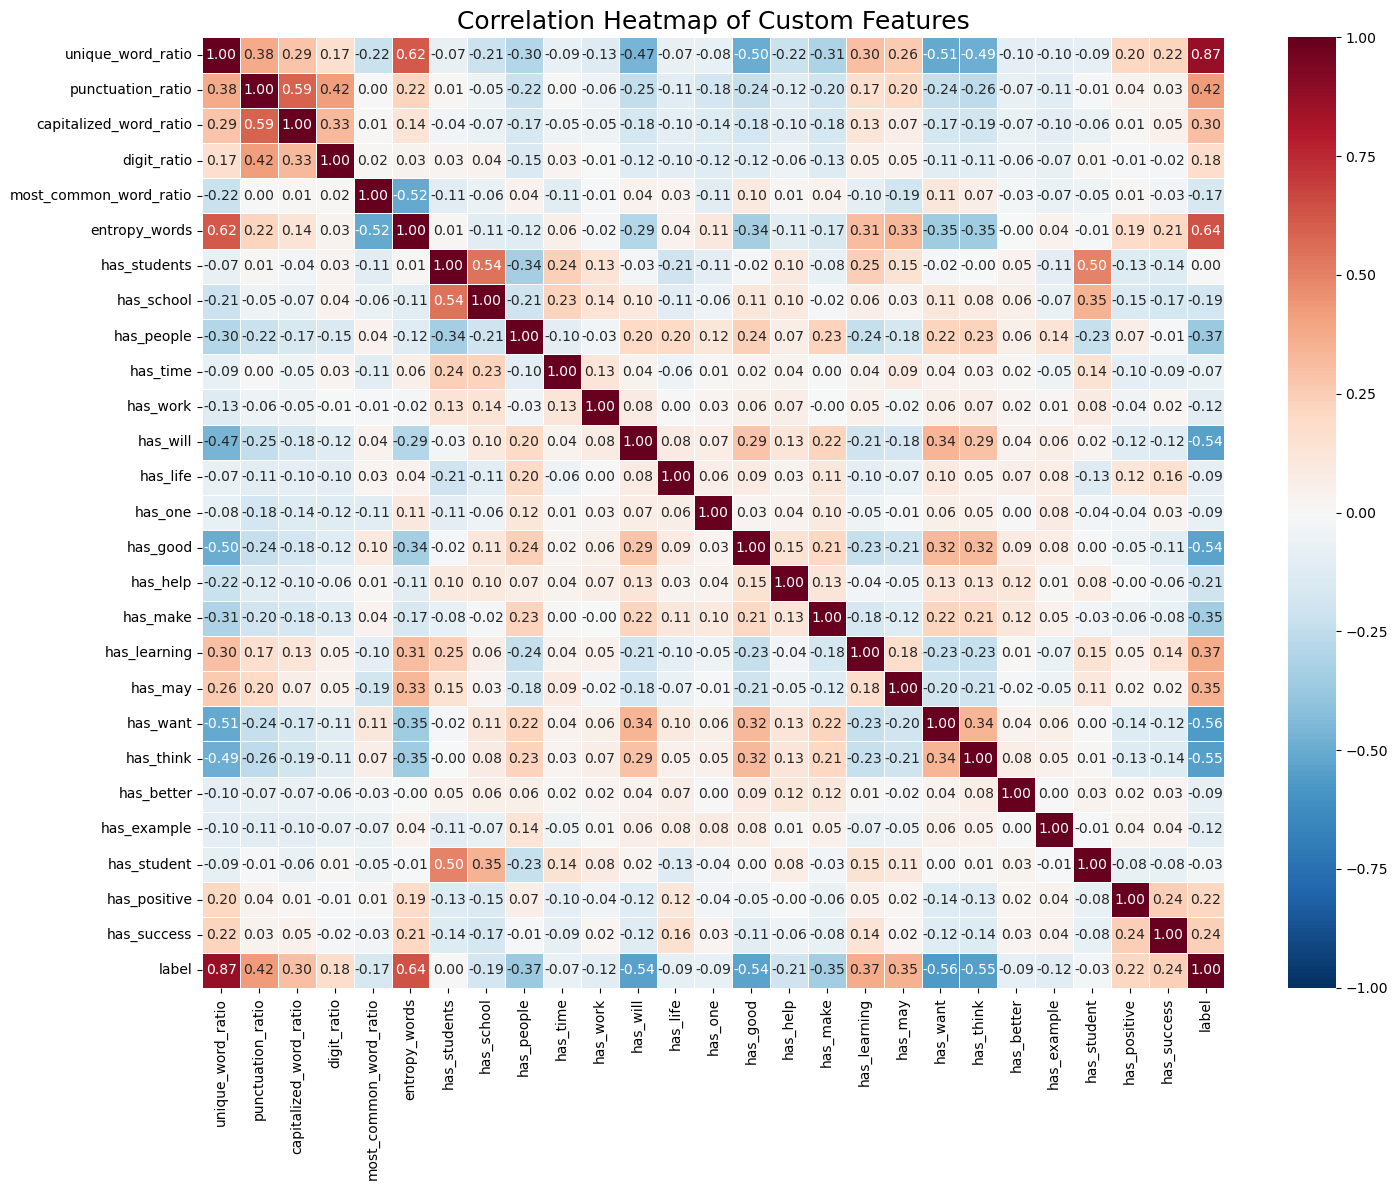

In [38]:
corr_matrix = custom_vector_df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(
    corr_matrix,
    annot=True,            # להוסיף את ערכי הקורלציה בתאים
    fmt=".2f",             # פורמט עם 2 ספרות אחרי הנקודה
    cmap="RdBu_r",          # אדום–כחול הפוך: כחול=שלילי, אדום=חיובי
    vmin=-1, vmax=1,       # תחום הקורלציה
    center=0,              # מרכז הצבע = 0
    linewidths=0.5         # קווים בין התאים
)
plt.title("Correlation Heatmap of Custom Features", fontsize=18)
plt.tight_layout()
plt.show()

# LogisticRegression

In [39]:
# --- Custom Features ---
X_custom = custom_vector_df.drop(columns=['label'])
y_custom = custom_vector_df['label']

scores_custom = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_custom,
    y_custom,
    cv=5,
    scoring="accuracy"
)
print("Custom Features CV accuracy:", scores_custom.mean())

# --- Word2Vec ---
X_w2v = df_w2v_scaled.drop(columns=['label'])
y_w2v = df_w2v_scaled['label']

scores_w2v = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_w2v,
    y_w2v,
    cv=5,
    scoring="accuracy"
)
print("Word2Vec CV accuracy:", scores_w2v.mean())

# --- Bag of Words ---
scores_bow = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_bow,
    y,
    cv=5,
    scoring="accuracy"
)
print("Bag of Words CV accuracy:", scores_bow.mean())

# --- TF-IDF Word ---
scores_tfidf_word = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_tfidf_word,
    y,
    cv=5,
    scoring="accuracy"
)
acc_tfidf_word = scores_tfidf_word.mean()
print("TF-IDF Word CV accuracy:", acc_tfidf_word)

# --- TF-IDF Char ---
scores_tfidf_char = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_tfidf_char,
    y,
    cv=5,
    scoring="accuracy"
)
acc_tfidf_char = scores_tfidf_char.mean()
print("TF-IDF Char CV accuracy:", acc_tfidf_char)

Custom Features CV accuracy: 0.9873542617247775
Word2Vec CV accuracy: 0.9948284520492775
Bag of Words CV accuracy: 0.997696285848613
TF-IDF Word CV accuracy: 0.9964270138784151
TF-IDF Char CV accuracy: 0.9968501119013169


In [40]:
# יצירת טבלת LR עם עמודת Model
results = pd.DataFrame({
    "Representation": ["Custom Features", "Word2Vec", "Bag of Words", "TF-IDF Word", "TF-IDF Char"],
    "Accuracy": [
        scores_custom.mean(),
        scores_w2v.mean(),
        scores_bow.mean(),
        acc_tfidf_word,
        acc_tfidf_char
    ],
    "Model": ["Logistic Regression"] * 5  # מוסיפים עמודת Model
})

# מיון לפי Accuracy
results = results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

results

,Representation,Accuracy,Model
0,Bag of Words,0.997696,Logistic Regression
1,TF-IDF Char,0.996850,Logistic Regression
2,TF-IDF Word,0.996427,Logistic Regression
3,Word2Vec,0.994828,Logistic Regression
4,Custom Features,0.987354,Logistic Regression


In [41]:
def evaluate_model(X, y, title):
    model = LogisticRegression(max_iter=1000)

    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    print(f"{title} CV accuracy:", scores.mean())

    y_pred = cross_val_predict(model, X, y, cv=5)

    cm = confusion_matrix(y, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

Custom Features CV accuracy: 0.9873542617247775


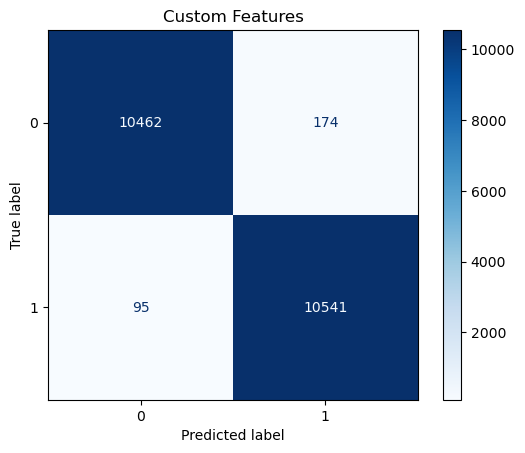

In [42]:
X_custom = custom_vector_df.drop(columns=['label'])
y_custom = custom_vector_df['label']

evaluate_model(X_custom, y_custom, "Custom Features")


Word2Vec CV accuracy: 0.9948284520492775


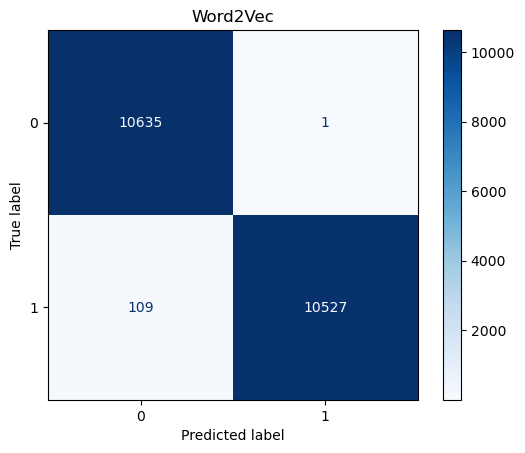

In [43]:
X_w2v = df_w2v_scaled.drop(columns=['label'])
y_w2v = df_w2v_scaled['label']

evaluate_model(X_w2v, y_w2v, "Word2Vec")


Bag of Words CV accuracy: 0.997696285848613


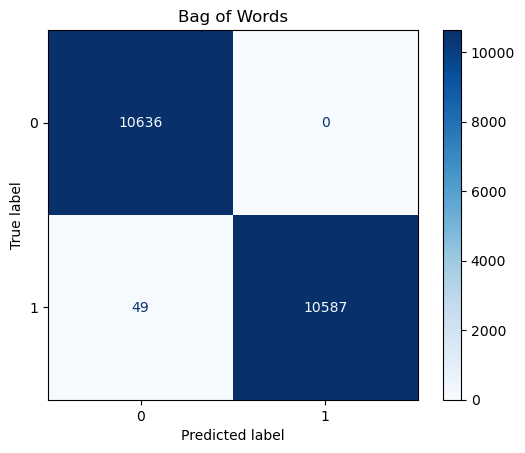

In [44]:
evaluate_model(X_bow, y, "Bag of Words")


TF-IDF Word CV accuracy: 0.9964270138784151


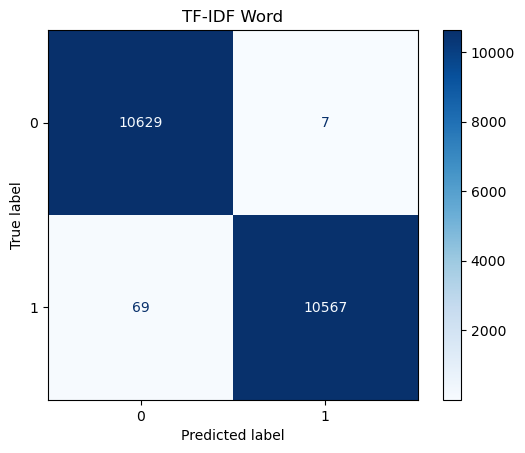

In [45]:
evaluate_model(X_tfidf_word, y, "TF-IDF Word")


TF-IDF Char CV accuracy: 0.9968501119013169


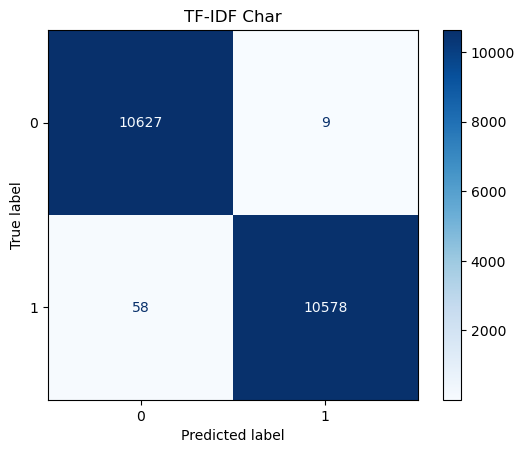

In [46]:
evaluate_model(X_tfidf_char, y, "TF-IDF Char")


# XGboost

In [47]:
def evaluate_xgboost(X, y, title):
    model = XGBClassifier(
        n_estimators=50,       
        max_depth=3,           
        learning_rate=0.2,
        subsample=1.0,
        colsample_bytree=1.0,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1              
    )


    scores = cross_val_score(model, X, y, cv=3, scoring="accuracy")
    print(f"{title} (XGBoost FAST) CV accuracy:", scores.mean())

    y_pred = cross_val_predict(model, X, y, cv=3)

    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{title} - XGBoost FAST")
    plt.show()

Custom Features (XGBoost FAST) CV accuracy: 0.9955340596425394


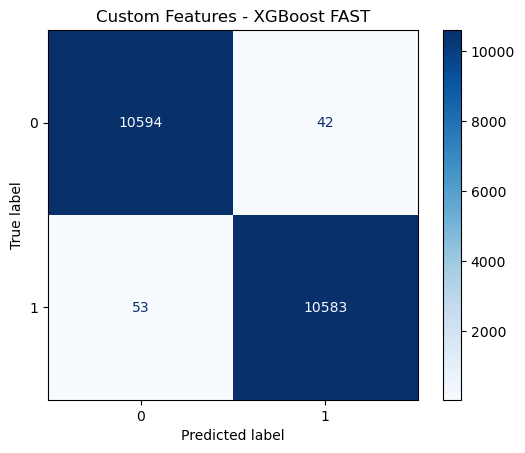

In [48]:
X_custom = custom_vector_df.drop(columns=['label'])
y_custom = custom_vector_df['label']

evaluate_xgboost(X_custom, y_custom, "Custom Features")


Word2Vec (XGBoost FAST) CV accuracy: 0.9909263329818677


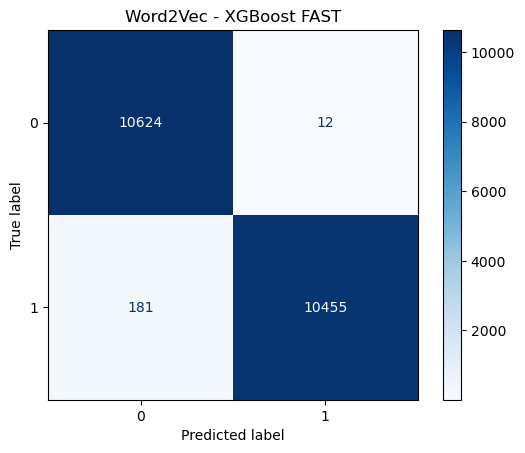

In [49]:
X_w2v = df_w2v_scaled.drop(columns=['label'])
y_w2v = df_w2v_scaled['label']

evaluate_xgboost(X_w2v, y_w2v, "Word2Vec")


Bag of Words (XGBoost FAST) CV accuracy: 0.9913497824009548


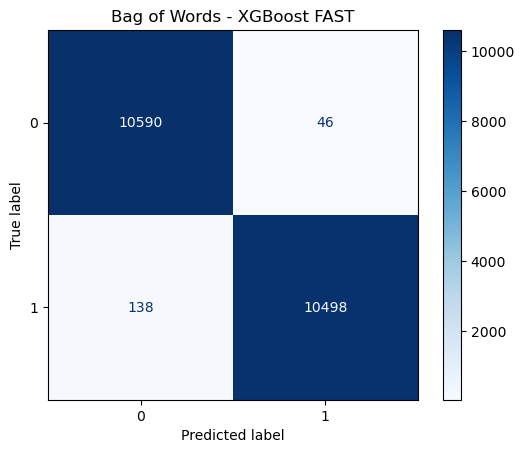

In [50]:
evaluate_xgboost(X_bow, y, "Bag of Words")


TF-IDF Word (XGBoost FAST) CV accuracy: 0.9908326021907294


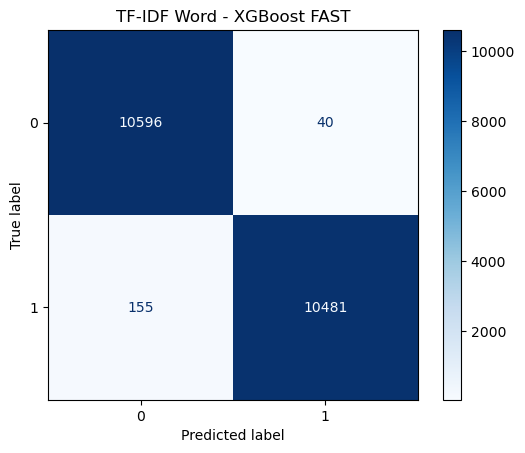

In [51]:
evaluate_xgboost(X_tfidf_word, y, "TF-IDF Word")


TF-IDF Char (XGBoost FAST) CV accuracy: 0.9964269652685549


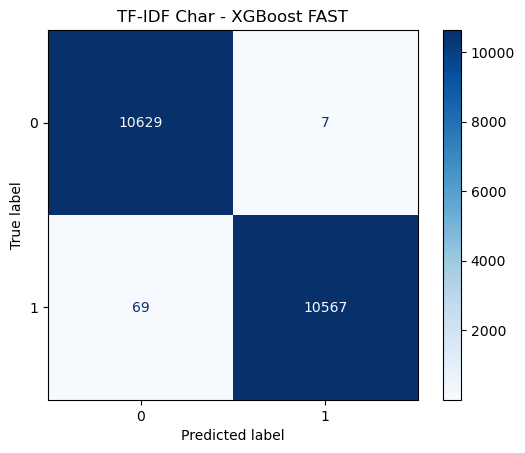

In [52]:
evaluate_xgboost(X_tfidf_char, y, "TF-IDF Char")


In [53]:
# ==========================
# XGBoost
# ==========================

# --- Custom Features ---
scores_xgb = {}
scores_xgb["Custom Features"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_custom, y_custom, cv=3, scoring="accuracy"
).mean()

# --- Word2Vec ---
scores_xgb["Word2Vec"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_w2v, y_w2v, cv=3, scoring="accuracy"
).mean()

# --- Bag of Words ---
scores_xgb["Bag of Words"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_bow, y, cv=3, scoring="accuracy"
).mean()

# --- TF-IDF Word ---
scores_xgb["TF-IDF Word"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_tfidf_word, y, cv=3, scoring="accuracy"
).mean()

# --- TF-IDF Char ---
scores_xgb["TF-IDF Char"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_tfidf_char, y, cv=3, scoring="accuracy"
).mean()

In [54]:
# ==========================
# יצירת טבלת תוצאות מסודרת
# ==========================

xgb_df = pd.DataFrame([
    {"Model": "XGBoost", "Features": k, "Accuracy": v}
    for k, v in scores_xgb.items()
]).sort_values(
    by="Accuracy", ascending=False
).reset_index(drop=True)

# הצגת הטבלה
print("XGBoost – Cross Validation Accuracy Results")
xgb_df

XGBoost – Cross Validation Accuracy Results


,Model,Features,Accuracy
0,XGBoost,TF-IDF Char,0.996427
1,XGBoost,Custom Features,0.995534
2,XGBoost,Bag of Words,0.991350
3,XGBoost,Word2Vec,0.990926
4,XGBoost,TF-IDF Word,0.990833


In [55]:
features = ["Custom Features", "Word2Vec", "Bag of Words", "TF-IDF Word", "TF-IDF Char"]

# רשימת Accuracy של LR
lr_acc = [
    scores_custom.mean(),
    scores_w2v.mean(),
    scores_bow.mean(),
    acc_tfidf_word,
    acc_tfidf_char
]

# רשימת Accuracy של XGBoost (מהטבלה xgb_df)
xgb_acc = [xgb_df.loc[xgb_df["Features"] == f, "Accuracy"].values[0] for f in features]

# בנייה של טבלת long format
combined_long = pd.DataFrame({
    "Representation": features * 2,           # כל פיצ'ר מופיע פעמיים
    "Model": ["Logistic Regression"] * 5 + ["XGBoost"] * 5,
    "Accuracy": lr_acc + xgb_acc
})


combined_long = combined_long.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

combined_long

,Representation,Model,Accuracy
0,Bag of Words,Logistic Regression,0.997696
1,TF-IDF Char,Logistic Regression,0.996850
2,TF-IDF Word,Logistic Regression,0.996427
3,TF-IDF Char,XGBoost,0.996427
4,Custom Features,XGBoost,0.995534
5,Word2Vec,Logistic Regression,0.994828
6,Bag of Words,XGBoost,0.991350
7,Word2Vec,XGBoost,0.990926
8,TF-IDF Word,XGBoost,0.990833
9,Custom Features,Logistic Regression,0.987354


In [56]:
model = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.2,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

model.fit(X_tfidf_char, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=-1,
              num_parallel_tree=None, ...)

In [57]:
def get_feature_importance_xgb(model, importance_type="gain"):
    booster = model.get_booster()
    importance_dict = booster.get_score(importance_type=importance_type)
    
    importance_df = pd.DataFrame({
        "feature": importance_dict.keys(),
        "importance": importance_dict.values()
    }).sort_values(by="importance", ascending=False)
    
    return importance_df

In [58]:
fi_gain = get_feature_importance_xgb(model, importance_type="gain")
fi_weight = get_feature_importance_xgb(model, importance_type="weight")
fi_cover = get_feature_importance_xgb(model, importance_type="cover")


In [59]:
fi_gain

,feature,importance
51,f32032,4953.984375
140,f158586,1697.990723
2,f2043,821.580566
59,f37631,697.779419
116,f110899,620.594727
...,...,...
48,f18896,0.878878
32,f10158,0.829204
147,f168330,0.693088
4,f3610,0.529023


In [60]:
fi_weight

,feature,importance
151,f178240,16.0
35,f10910,16.0
1,f1508,16.0
0,f1279,13.0
51,f32032,9.0
...,...,...
60,f37665,1.0
56,f35706,1.0
53,f32946,1.0
52,f32545,1.0


In [61]:
fi_cover

,feature,importance
51,f32032,3011.674072
2,f2043,2682.750000
140,f158586,2540.411865
50,f24027,1791.198853
89,f71127,1789.184448
...,...,...
85,f62730,5.601816
7,f5049,4.924029
45,f12225,4.223438
134,f154457,4.184599


In [66]:
tfidf_char.get_feature_names_out()
feature_names = tfidf_char.get_feature_names_out()

def map_xgb_feature(f):
    return feature_names[int(f[1:])]
fi_gain["ngram"] = fi_gain["feature"].apply(map_xgb_feature)
fi_weight["ngram"] = fi_weight["feature"].apply(map_xgb_feature)

In [69]:
fi_gain.head(20)

,feature,importance,ngram
51,f32032,4953.984375,al
140,f158586,1697.990723,tio
2,f2043,821.580566,2.
59,f37631,697.779419,ati
116,f110899,620.594727,nce
8,f5252,546.727112,do
89,f71127,476.076172,fos
17,f6338,471.949585,get
113,f105766,438.764740,ment
83,f62515,405.526550,eng


In [68]:
fi_weight

,feature,importance,ngram
151,f178240,16.0,’s
35,f10910,16.0,th
1,f1508,16.0,.
0,f1279,13.0,-
51,f32032,9.0,al
...,...,...,...
60,f37665,1.0,atio
56,f35706,1.0,arly
53,f32946,1.0,alu
52,f32545,1.0,ali
